In [1]:
%load_ext autoreload
%autoreload 2

### Подключение необходимых библиотек и модулей

In [2]:
import numpy as np

from knn import KNNClassifier, distances, cross_validation

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

from skimage.io import imshow
from skimage.transform import rotate
from skimage.transform import AffineTransform, warp
from skimage.filters import gaussian

import matplotlib.pyplot as plt
import seaborn as sn

from time import time
from pprint import pprint
from math import ceil
from itertools import product

### Загрузка датасета MNIST

In [3]:
X, y = fetch_openml('mnist_784', return_X_y=True)

(70000, 784)

### Нормализация изображений
$\forall x \in X: x_{ij} \in [0, 1]$

In [4]:
X = X.astype(np.float64) / 256.0

### Вывод нескольких объектов из датасета для примера

In [5]:
def convert2image(X: np.ndarray):
    return X.reshape((28, 28))

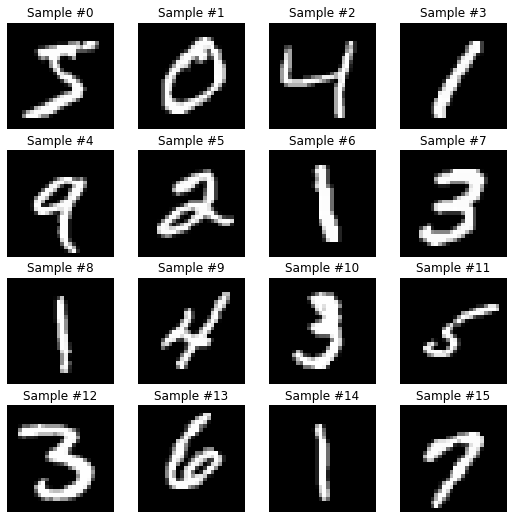

In [6]:
def show_images(images, true_labels=None, pred_labels=None):
    fig = plt.figure(figsize=(9, 9))
    rows = ceil(len(images) ** 0.5)
    gs = plt.GridSpec(rows, rows)
    
    for i, image in enumerate(images):
        ax = fig.add_subplot(gs[i // rows, i % rows])
        ax.axis('off')
        
        title = 'Sample #{}'.format(i)
        if true_labels is not None:
            title = ' [true: {}]'.format(true_labels[i])
        if pred_labels is not None:
            title += ' | [model: {}]'.format(pred_labels[i])
            
        ax.set_title(title)
        ax.imshow(convert2image(image), cmap='gray')
        
show_images(X[:16])

### Разбиение датасета на обучающую (60.000 объектов ) и тестовую выборку (10.000 объектов)

In [7]:
X, y = X.astype(np.float64), y.astype(np.float64)
X_train, X_test, y_train, y_test = X[:-10000],X[-10000:], y[:-10000],y[-10000:]
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### Список с параметрами для всех тестируемых моделей

In [8]:
model_params = []
for strategy in ('my_own', 'brute', 'kd_tree', 'ball_tree'):
    
    for metric in ('euclidean', 'cosine'):
        if strategy in ('kd_tree', 'ball_tree') and metric == 'cosine':
            continue
            
        for weights in (True, False):
            model_params.append({
                'k': 5,
                'strategy': strategy,
                'metric': metric,
                'weights': weights, 
                'n_jobs': -1
            })

In [9]:
def compress_params(params):
    return '{}({}) [{}{}]'.format(
        params['strategy'],
        params['k'],
        params['metric'], 
        ', weighted' if params['weights'] else ''
    )

for params in model_params:
    print(compress_params(params))

my_own(5) [euclidean, weighted]
my_own(5) [euclidean]
my_own(5) [cosine, weighted]
my_own(5) [cosine]
brute(5) [euclidean, weighted]
brute(5) [euclidean]
brute(5) [cosine, weighted]
brute(5) [cosine]
kd_tree(5) [euclidean, weighted]
kd_tree(5) [euclidean]
ball_tree(5) [euclidean, weighted]
ball_tree(5) [euclidean]


### Выбор подмножества параметров длинной 10, 20, 100. 
#### Производится случайным образом.

In [10]:
np.random.seed(42)
feature_indices = [np.random.randint(0, X.shape[1], size) for size in (10, 20, 100)]

### Измерение времени поиска 5 ближайших соседей для всех возможных алгоритмов

In [11]:
print('Find neighbours in each model:')

global_start = time()

timings = []
for params in model_params:
    model = KNNClassifier(**params)
    timings.append((params, []))
    for features in feature_indices:    
        model.fit(X_train[:, features], y_train)
        
        start = time()
        model.find_kneighbors(X_test[:, features])
        end = time()
        
        timings[-1][1].append(end - start)
        print('\t' + compress_params(params) + ' on {} features: done in {:.4f}s'.format(
            len(features),
            end - start
        ))
        

print("Done in {:.4f}s!".format(time() - global_start))

Find neighbours in each model:
	my_own(5) [euclidean, weighted] on 10 features: done in 5.0122s
	my_own(5) [euclidean, weighted] on 20 features: done in 5.2342s
	my_own(5) [euclidean, weighted] on 100 features: done in 5.2478s
	my_own(5) [euclidean] on 10 features: done in 5.2716s
	my_own(5) [euclidean] on 20 features: done in 5.1296s
	my_own(5) [euclidean] on 100 features: done in 5.0625s
	my_own(5) [cosine, weighted] on 10 features: done in 5.2397s
	my_own(5) [cosine, weighted] on 20 features: done in 5.3188s
	my_own(5) [cosine, weighted] on 100 features: done in 5.1582s
	my_own(5) [cosine] on 10 features: done in 5.6083s
	my_own(5) [cosine] on 20 features: done in 5.4416s
	my_own(5) [cosine] on 100 features: done in 5.4228s
	brute(5) [euclidean, weighted] on 10 features: done in 11.0825s
	brute(5) [euclidean, weighted] on 20 features: done in 10.1217s
	brute(5) [euclidean, weighted] on 100 features: done in 10.7710s
	brute(5) [euclidean] on 10 features: done in 11.0322s
	brute(5) [e

### Определение наилучшего алгоритма 

In [14]:
for i, features in enumerate(feature_indices):
    best_params, timing = min(timings, key=lambda entry: entry[1][i])
    print("Best model for {} features:\n\t{}: done in {:.4f}s".format(
        features.shape[0],
        compress_params(best_params), 
        timing[i])
     )

Best model for 10 features:
	kd_tree(5) [euclidean]: done in 0.7030s
Best model for 20 features:
	kd_tree(5) [euclidean, weighted]: done in 1.0057s
Best model for 100 features:
	my_own(5) [euclidean]: done in 5.0625s


In [15]:
scoring_all = []
for params in model_params:
    
    # поскольку метод brute совпадает с my_own по метрикам, опустим его
    if params['strategy'] == 'brute':
        continue
    
    model = KNNClassifier(**params)
        
    start = time()
    score = cross_validation.knn_cross_val_score(
        X_train, y_train,
        k_list=list(range(1, 11)),
        **params
    )
    end = time()

    scoring_all.append((params, score))
    print('\t' + compress_params(params) + ': done in {:.4f}s'.format(end - start))

	my_own(5) [euclidean, weighted]: done in 30.8722s
	my_own(5) [euclidean]: done in 29.3443s
	my_own(5) [cosine, weighted]: done in 29.4080s
	my_own(5) [cosine]: done in 29.3967s
	kd_tree(5) [euclidean, weighted]: done in 442.9105s
	kd_tree(5) [euclidean]: done in 444.6947s
	ball_tree(5) [euclidean, weighted]: done in 177.5307s
	ball_tree(5) [euclidean]: done in 177.1007s


### Оценки качества для различных моделей

In [16]:
def model_score_plot(scoring):
    fig = plt.figure(figsize=(10, 4))
    
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    
    for model, score in scoring:
        scoring_curve = []
        for k, values in score.items():
            scoring_curve.append(np.mean(values))

        plt.plot(list(range(1, 11)), scoring_curve, label=compress_params(model))

    plt.legend()

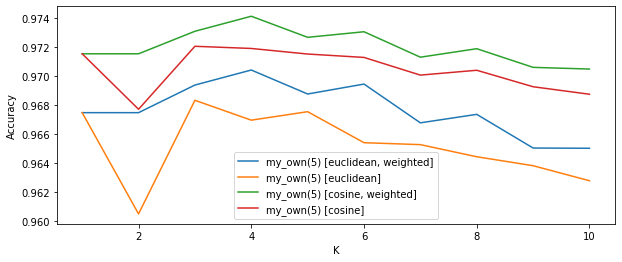

In [17]:
model_score_plot(scoring_all[:4])

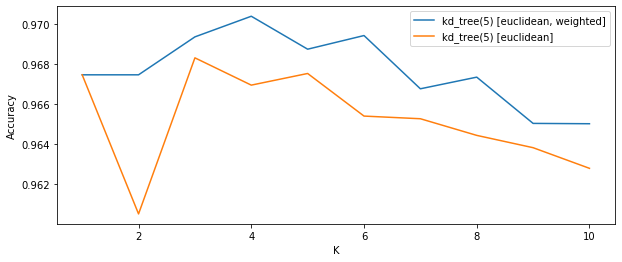

In [18]:
model_score_plot(scoring_all[4:6])

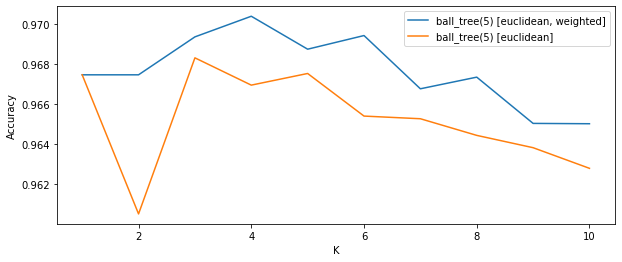

In [19]:
model_score_plot(scoring_all[6:])

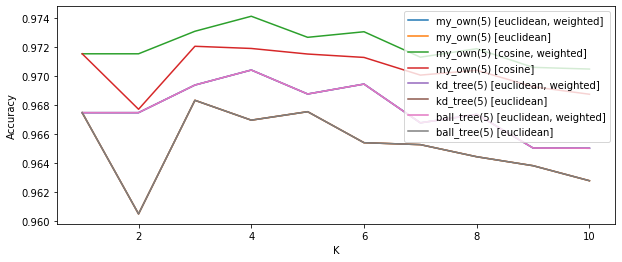

In [20]:
model_score_plot(scoring_all)

__Вывод__ <br>
Оценка качества одинакова для методов _brute_ и *my_own*, а также для *kd_tree* и *ball_tree* на евклидовых метриках. <br>
Однако _косинусная метрика_ (не применимая к *kd_tree* и *ball_tree*) показывает себя лучше для переборных методов. <br>
_Взвешенные_ предсказания классов работают лучше для всех методов. <br>
Лучший по качеству алгоритм - полностью переборный, однако он существенно медленнее для поиска ближайших соседей. 

### Применение лучшего (my_own) алгоритма к тестовой выборке

In [21]:
params = {
    'k': 4,
    'strategy': 'my_own',
    'metric': 'cosine', 
    'weights': True, 
    'n_jobs': -1
}

scores = cross_validation.knn_cross_val_score(X_train, y_train, [4], **params)
scores

defaultdict(list, {4: [0.97545, 0.9732, 0.97365]})

### Подсчет точности лучшего алгоритма

In [22]:
cross_cal_accuracy = np.mean(scores[4][1])
cross_cal_accuracy

0.9732

In [23]:
model = KNNClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [24]:
accuracy = np.mean(y_pred == y_test)
accuracy

0.9752

### Объекты, на которых алгоритм ошибся

In [25]:
wrong_X = X_test[y_pred != y_test]
wrong_y = y_pred[y_pred != y_test]
correct_y = y_test[y_pred != y_test]

wrong_X.shape

(248, 784)

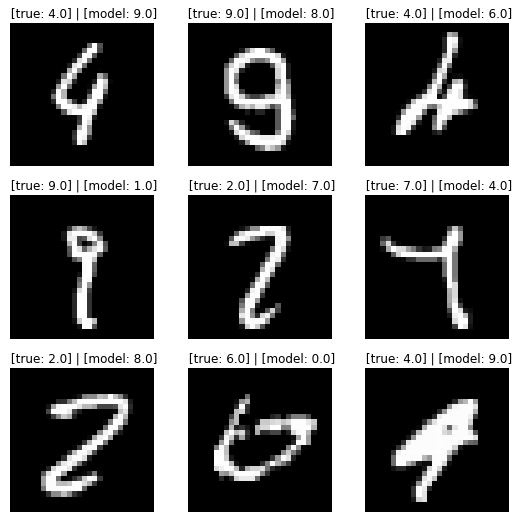

In [26]:
samples_n = 9
show_images(wrong_X[:samples_n], correct_y[:samples_n], wrong_y[:samples_n])

### Сonfusion matrix

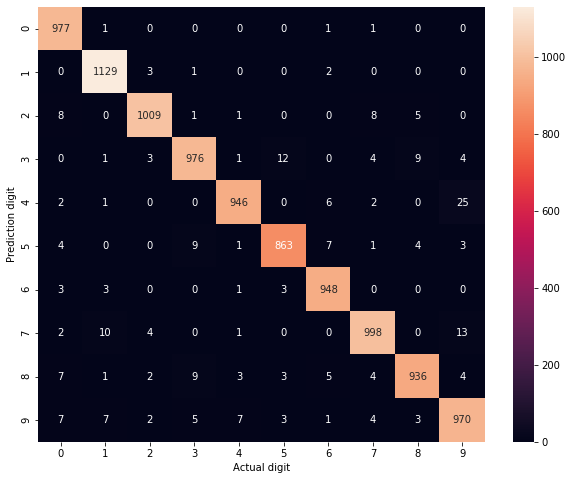

In [27]:
def plot_confusion_matrix(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    sn.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.xlabel("Actual digit")
    plt.ylabel("Prediction digit")
    
plot_confusion_matrix(y_test, y_pred)

### Подбор параметров для увеличения выборки

In [28]:
def unison_shuffle(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

### Вращение цифр

Для начала осуществляется поворот одного объекта из датасета и оценка результата

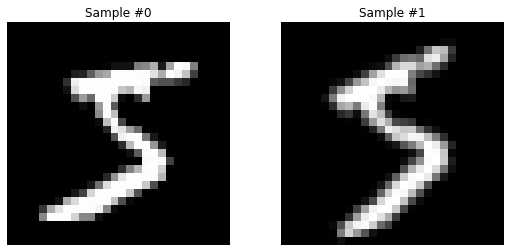

In [29]:
show_images([X[0], rotate(convert2image(X[0]), 15)])

Подбор угла для увеличения выборки за счёт применения к части (в силу ограничения по памяти) исходной различных поворотов

In [30]:
size = 20000
part_ind = np.random.randint(0, X.shape[1], size)
for angle in range(-15, 16, 5):
    
    # если поворота не происходит, пропускаем
    if not angle:
        continue
        
    rotated = np.empty((size, X_train.shape[1]))
    for i, x in enumerate(X_train[part_ind]):
        rotated[i] = rotate(convert2image(x), angle).reshape((28 * 28))
 
    X_rotated = np.vstack([X_train, rotated])
    y_rotated = np.hstack([y_train, y_train[part_ind]])
    
    del rotated
    
    X_rotated, y_rotated = unison_shuffle(X_rotated, y_rotated)
    
    scores = cross_validation.knn_cross_val_score(
        X_rotated, y_rotated,
        [4],
        **params
    )
    
    del X_rotated
    del y_rotated
    
    print('Cross-val accuracy for angle {} is {}'.format(angle, np.mean(scores[4][1])))    

Cross-val accuracy for angle -15 is 0.9804627442156973
Cross-val accuracy for angle -10 is 0.9791877601529981
Cross-val accuracy for angle -5 is 0.9817002287471407
Cross-val accuracy for angle 5 is 0.9809127385907677
Cross-val accuracy for angle 10 is 0.9808752390595118
Cross-val accuracy for angle 15 is 0.9830877114036074


__Вывод__: согласно результатам кросс-валидации, наилучшим значением для угла поворота является 10 и -10 градусов.

### Сдвиги цифр

In [31]:
def shift_image(image, vector):
    transform = AffineTransform(translation=vector)
    shifted = warp(image, transform, mode='wrap', preserve_range=True)

    return shifted.astype(image.dtype)

Для начала осуществляется сдвиг одного объекта из датасета и оценка результата

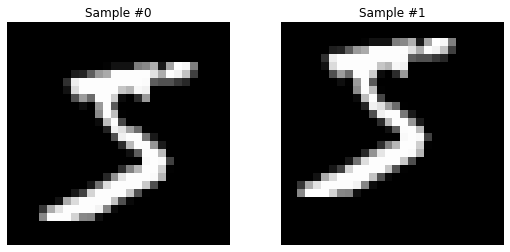

In [32]:
show_images([X[0], shift_image(convert2image(X[0]), (2, 3))])

Подбор смещения для увеличения выборки за счёт применения к части (в силу ограничения по памяти) исходной различных смещений

In [33]:
size = 20000
part_ind = np.random.randint(0, X.shape[1], size)

# полный подсчёт по всем возможным сдвигам (очень долгий, ~1.5 часа)
# for shift in product(range(-3, 4), range(-3, 4)):
for shift in ((0, 1), (0, 2), (0, 3), (1, 0), (2, 0), (3, 0)):
    
    # если смещения не происходит, пропускаем
    if shift == (0, 0):
        continue
            
    shifted = np.empty((size, X_train.shape[1]))
    for i, x in enumerate(X_train[part_ind]):
        shifted[i] = shift_image(convert2image(x), shift).reshape((28 * 28))
 
    X_shifted = np.vstack([X_train, shifted])
    y_shifted = np.hstack([y_train, y_train[part_ind]])
    
    del shifted
    
    X_shifted, y_shifted = unison_shuffle(X_shifted, y_shifted)
    
    scores = cross_validation.knn_cross_val_score(
        X_shifted, y_shifted,
        [4],
        **params
    )
    
    del X_shifted
    del y_shifted
    
    print('Cross-val accuracy for shift {} is {}'.format(shift, np.mean(scores[4][1])))    

Cross-val accuracy for shift (0, 1) is 0.982675216559793
Cross-val accuracy for shift (0, 2) is 0.9811002362470469
Cross-val accuracy for shift (0, 3) is 0.9826377170285372
Cross-val accuracy for shift (1, 0) is 0.981625229684629
Cross-val accuracy for shift (2, 0) is 0.9806127423407207
Cross-val accuracy for shift (3, 0) is 0.9831252109348633


__Вывод__: согласно результатам кросс-валидации, наилучшим значением для сдвига являются (0, 3) и (3, 0).

### Применение фильтра

In [34]:
def filter_image(image, s):
    return gaussian(image, sigma=s)

Для начала фильтр применяется к одному объекту из датасета и оценивается результат

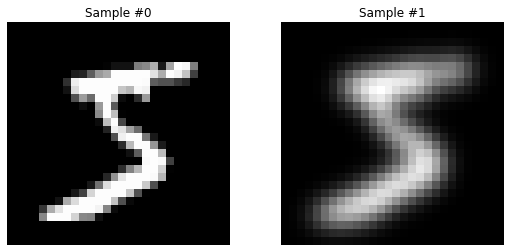

In [35]:
show_images([X[0], filter_image(convert2image(X[0]), 1.5)])

Подбор дисперсии для увеличения выборки за счёт применения к части (в силу ограничения по памяти) исходной фильтра Гаусса

In [36]:
size = 20000
part_ind = np.random.randint(0, X.shape[1], size)

for sigma in (0.5, 1.0, 1.5):
                
    filtred = np.empty((size, X_train.shape[1]))
    for i, x in enumerate(X_train[part_ind]):
        filtred[i] = filter_image(convert2image(x), sigma).reshape((28 * 28))
 
    X_filtred = np.vstack([X_train, filtred])
    y_filtred = np.hstack([y_train, y_train[part_ind]])
    
    del filtred
    
    X_filtred, y_filtred = unison_shuffle(X_filtred, y_filtred)
    
    scores = cross_validation.knn_cross_val_score(
        X_filtred, y_filtred,
        [4],
        **params
    )
    
    del X_filtred
    del y_filtred
    
    print('Cross-val accuracy for sigma {} is {}'.format(sigma, np.mean(scores[4][1])))    

Cross-val accuracy for sigma 0.5 is 0.9817752278096524
Cross-val accuracy for sigma 1.0 is 0.9791127610904864
Cross-val accuracy for sigma 1.5 is 0.9799002512468594


__Вывод__: согласно результатам кросс-валидации, наилучшим значением для дисперсии фильтра Гаусса является 0.5.

### Зачем нужно размножение обучающей выборки?

Каждое из преобразований убирает некоторую часть ошибок. <br>
При использовании всех преобразований для полной выборки это можно было бы проанализировать исходя из confusion matrix, однако размер полученной выборки был бы слишком большим для вычисления на лэптопе. <br>

Поворот на некоторый угол позволяет исправить ситуацию, когда тестовое изображение может быть слегка наклонено относительно обучающей выборки (например, если угол наклона почерка человека отличается в разных документах).

Сдвиг внутри изображения позволяет учитывать различное положение цифры при начертании. Кто-то напишет цифру не ровно посередине квадрата, а чуть левее или правее, выше или ниже.

Фильтр Гаусса позволяет уменьшить влияние степени нажима при начертании. Яркость цифры также становится менее важной. Но самое главное - гауссов фильтр размывает резкие края плохо детализированного изображения. Граница становится мягкой, и одни и те же цифры становятся более похожи друг на друга.

### Что будет, если применить те же аугментации к тестовой выборке?

Влияние видов преобразований уже было описано.

Если применить их, чтобы размножить тестовую выборку, а не обучающую, мы получим более честные результаты метрики accuracy при тестировании, поскольку это позволит имитировать различные виды начертания цифр различными людьми, которые могли не встречаться в обучающей выборке.